# Topology
This example reproduces the topology constraint.

In [2]:
from quadcoil import quadcoil
from quadcoil.quantity import K_theta, Phi_with_net_current, K2, K
from quadcoil.io import simsopt_coil_from_qp

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import time

In [4]:
from simsopt import load
from simsopt.geo import curves_to_vtk
from simsopt.field import BiotSavart
from simsopt.objectives.fluxobjective import SquaredFlux

## Loading data

In [5]:
# The example is li383.
_, plasma_surface = load('surfaces.json')
net_poloidal_current_amperes = 11884578.094260072
import jax
jax.config.update('jax_enable_x64', True)

## Running NESCOIL for comparison

In [6]:
# First, test with the NESCOIL problem, auto-generating WS.
print('Running nescoil, with auto-generated '\
      'winding surface.')
nescoil_out_dict, nescoil_qp, nescoil_dofs, _ = quadcoil(
    nfp=plasma_surface.nfp,
    stellsym=plasma_surface.stellsym,
    mpol=4,
    ntor=4,
    plasma_dofs=plasma_surface.get_dofs(),
    plasma_mpol=plasma_surface.mpol,
    plasma_ntor=plasma_surface.ntor,
    net_poloidal_current_amperes=net_poloidal_current_amperes,
    net_toroidal_current_amperes=0.,
    plasma_coil_distance=plasma_surface.minor_radius(),
    # Set the objective to 
    # f_B
    objective_name='f_B',
    objective_weight=None,
    objective_unit=None,
    # Set the output metrics to f_B and f_K
    metric_name=('f_B', 'f_K')
)

Running nescoil, with auto-generated winding surface.


## Running QUADCOIL, constraining the coils to be purely poloidal


In [8]:
if net_poloidal_current_amperes > 0:
    K_theta_sign = '>='
else:
    K_theta_sign = '<='
print('K_theta should be', K_theta_sign, '0')

K_theta should be >= 0


In [9]:
# Running QUADCOIL with topology constraint
print('Running quadcoil, with auto-generated '\
      'winding surface and K_theta constraint.')
out_dict, qp, dofs, status = quadcoil(
    nfp=plasma_surface.nfp,
    stellsym=plasma_surface.stellsym,
    mpol=4,
    ntor=4,
    plasma_dofs=plasma_surface.get_dofs(),
    plasma_mpol=plasma_surface.mpol,
    plasma_ntor=plasma_surface.ntor,
    net_poloidal_current_amperes=net_poloidal_current_amperes,
    net_toroidal_current_amperes=0.,
    plasma_coil_distance=plasma_surface.minor_radius(),
    # Set the objective to 
    # f_B
    objective_name='f_B',
    # Set the constraint to K_theta
    constraint_name=('K_theta',),
    constraint_type=('>=',),
    constraint_value=np.array([0.,]),
    constraint_unit=(None,),
    # Set the output metrics to f_B and f_K
    metric_name=('f_B', 'f_K'),
)

Running quadcoil, with auto-generated winding surface and K_theta constraint.


In [ ]:
# Running QUADCOIL with topology constraint (logsumexp mode)
# The logsumexp function is a smooth, convex approximation 
# for max(a, b). The approx mode is intended for quasi-single-stage 
# optimization. Here, the example is intended to show that the 
# a good approximate solution can be obtained using this approx for 
# max, abs, L1, etc. 
print('Running quadcoil, with auto-generated '\
      'winding surface and K_theta constraint.')
out_dict_lse, qp_lse, dofs_lse, status_lse = quadcoil(
    nfp=plasma_surface.nfp,
    stellsym=plasma_surface.stellsym,
    mpol=4,
    ntor=4,
    plasma_dofs=plasma_surface.get_dofs(),
    plasma_mpol=plasma_surface.mpol,
    plasma_ntor=plasma_surface.ntor,
    net_poloidal_current_amperes=net_poloidal_current_amperes,
    net_toroidal_current_amperes=0.,
    plasma_coil_distance=plasma_surface.minor_radius(),
    # Set the objective to 
    # f_B
    objective_name='f_B',
    # Set the constraint to K_theta
    constraint_name=('K_theta',),
    constraint_type=('>=',),
    constraint_value=np.array([0.,]),
    constraint_unit=(None,),
    # Set the output metrics to f_B and f_K
    metric_name=('f_B', 'f_K'),
    smoothing='approx'
)

Running quadcoil, with auto-generated winding surface and K_theta constraint.


In [16]:
print(
    'The solution of the exact multi-constraint problem '
    'should be consistent with the log-sum-exp approximation.')
print('f_B with K_theta constraints (exact):', out_dict['f_B']['value'])
print('f_B with K_theta constraints (LSE):  ', out_dict_lse['f_B']['value'])
print('f_B with no constraints:             ', nescoil_out_dict['f_B']['value'])
print('Minimum K_theta with constraints (exact):', jnp.min(K_theta(qp, dofs)))
print('Minimum K_theta with constraints (LSE):  ', jnp.min(K_theta(qp_lse, dofs_lse)))
print('Minimum K_theta without constraints:     ', jnp.min(K_theta(qp, nescoil_dofs)))

The solution of the exact multi-constraint problem should be consistent with the log-sum-exp approximation.
f_B with K_theta constraints (exact): 0.07299594266241782
f_B with K_theta constraints (LSE):   0.07333192483003154
f_B with no constraints:              0.04290742267896888
Minimum K_theta with constraints (exact): -11.438837561756372
Minimum K_theta with constraints (LSE):   32212.422903660685
Minimum K_theta without constraints:      -23835239.961569786


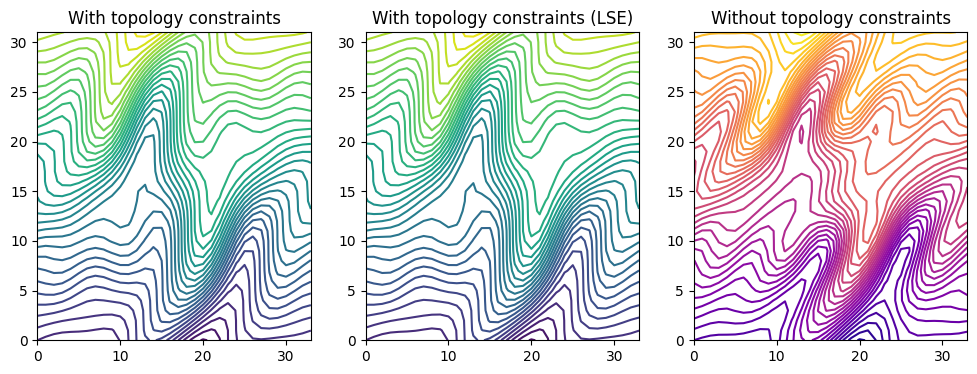

In [15]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title('With topology constraints')
plt.contour(Phi_with_net_current(qp, dofs), levels=40)
plt.subplot(1,3,2)
plt.title('With topology constraints (LSE)')
plt.contour(Phi_with_net_current(qp_lse, dofs_lse), levels=40)
plt.subplot(1,3,3)
plt.title('Without topology constraints')
plt.contour(Phi_with_net_current(qp, nescoil_dofs), levels=40, cmap='plasma')

## Coil cutting

Cutting complete. Number of coils/half field period: 5
Squared flux from filament coils 0.07812669192821341
Squared flux from winding surface 0.07299504672168021


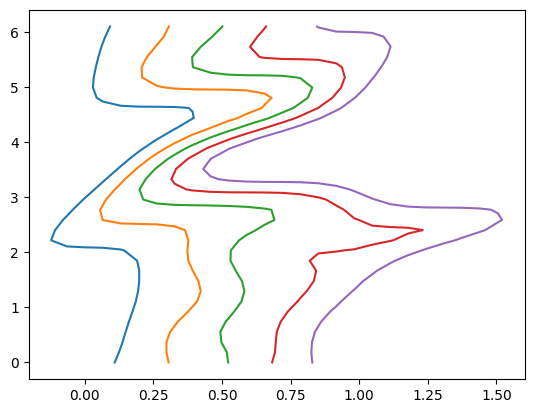

In [10]:
coils = simsopt_coil_from_qp(
    qp=qp, 
    dofs=dofs,
    coils_per_half_period=5, 
    theta_shift=0,
    order=10, ppp=40)
curves_to_vtk([ci.curve for ci in coils], 'test_coils')

bs = BiotSavart(coils)
Js = SquaredFlux(qp.plasma_surface.to_simsopt(), bs)
print('Squared flux from filament coils', Js.J())
print('Squared flux from winding surface', out_dict['f_B']['value'])

## Output structure
The following blocks look at the structure of outputs from QUADCOIL.

In [11]:
# Printing the structure of a nested dictionary by recursion
def print_tree_structure(d, indent=0, tab = '    '):
    for key, value in d.items():
        if isinstance(value, dict):
            print(tab * indent + '\'' + str(key) + '\'' + ': {')
            print_tree_structure(value, indent + 1)
            print(tab * indent + '},')
        else:
            if jnp.isscalar(value):
                print(tab * indent + '\'' + str(key) + '\'' + ': ' + str(value) + ',')
            else:
                print(tab * indent + '\'' + str(key) + '\': array(dtype=' + str(value.dtype) + ', shape=' + str(value.shape) + '),')

In [12]:
print_tree_structure(out_dict)

'f_B': {
    'grad': {
        'df_dconstraint_value': array(dtype=float64, shape=(1,)),
        'df_dnet_poloidal_current_amperes': 1.2286671349761704e-08,
        'df_dnet_toroidal_current_amperes': 7.931921249969801e-09,
        'df_dplasma_coil_distance': 0.9521751194934195,
        'df_dplasma_dofs': array(dtype=float64, shape=(187,)),
    },
    'value': 0.07299504672168021,
},
'f_K': {
    'grad': {
        'df_dconstraint_value': array(dtype=float64, shape=(1,)),
        'df_dnet_poloidal_current_amperes': 12338812.983117398,
        'df_dnet_toroidal_current_amperes': 1022832.4956184626,
        'df_dplasma_coil_distance': 242672585278193.72,
        'df_dplasma_dofs': array(dtype=float64, shape=(187,)),
    },
    'value': 73333747681697.27,
},
